In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import cv2

In [ ]:
# Image and grid config
IMG_SIZE = 64
GRID_SIZE = 4
CELL_SIZE = IMG_SIZE // GRID_SIZE

# Generate synthetic data: one square (object) per image
def generate_data(num_samples):
    X = np.zeros((num_samples, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    y = np.zeros((num_samples, GRID_SIZE, GRID_SIZE, 5))  # 5 = [x, y, w, h, conf]

    for i in range(num_samples):
        x = np.random.randint(0, IMG_SIZE - 20)
        y_coord = np.random.randint(0, IMG_SIZE - 20)
        w = np.random.randint(10, 20)
        h = np.random.randint(10, 20)
        X[i, y_coord:y_coord+h, x:x+w, :] = 1.0  # White box (object)

        # Find grid cell
        cx = x + w / 2
        cy = y_coord + h / 2
        grid_x = int(cx // CELL_SIZE)
        grid_y = int(cy // CELL_SIZE)
        # Normalize coordinates relative to the cell
        rel_x = (cx % CELL_SIZE) / CELL_SIZE
        rel_y = (cy % CELL_SIZE) / CELL_SIZE
        rel_w = w / IMG_SIZE
        rel_h = h / IMG_SIZE
        y[i, grid_y, grid_x] = [rel_x, rel_y, rel_w, rel_h, 1.0]  # conf = 1
    
    return X, y

# Generate sample data
X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(100)

# Visualize sample
plt.imshow(X_train[0])
plt.title("Sample Image")
plt.show()

In [3]:
type(y_train)

numpy.ndarray

In [4]:
y_train.shape

(1000, 4, 4, 5)

In [5]:
X_train.shape

(1000, 64, 64, 3)

In [ ]:
X_train[0]

In [8]:
y_train[0][1]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [2]:
# Function to preprocess the image
def preprocess_image(image_path):
    
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    #img = img / 255.0

    # Convert the image from BGR to RGB (as YOLOv5 uses RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to 640x640 (YOLOv5 expects a 640x640 input)
    #img_resized = cv2.resize(img, (640, 640))
    #img_resized = cv2.resize(img, (256, 256))
    #img_resized = cv2.resize(img, (128, 128))
    img_resized = cv2.resize(img, (144, 144))
    
    img_resized = img_resized/255.0

    return img_resized

In [3]:
# Get all image files
images_files = []
for file in os.listdir('Images'):
    if file.endswith(('.jpg', '.png')):
        images_files.append(file)    

In [4]:
# Get all label files
label_files = []
for file in os.listdir('dataset/labels/train'):
    if file.endswith('.txt'):
        label_files.append(file)    

In [5]:
# Get all label files for validation
label_val_files = []
for file in os.listdir('dataset/labels/val'):
    if file.endswith('.txt'):
        label_val_files.append(file)    

In [6]:
len(label_val_files)

1126

In [7]:
len(os.listdir('dataset/images/train'))

4500

In [8]:
#SPLIT_RATIO = 0.8  # 80% train, 20% validation
SPLIT_RATIO = 0.001
#SPLIT_RATIO = 0.25

In [9]:
split_index = int(len(images_files) * SPLIT_RATIO)
split_index

5

In [10]:
split_data = {
    "train": images_files[:split_index],
    "val": images_files[split_index:]
}

In [39]:
split_data['train']

['00000000.jpg',
 '00000001.jpg',
 '00000002.jpg',
 '00000003.jpg',
 '00000004.jpg']

In [46]:
train_data_images = len(split_data['train'])
print(train_data_images)

5


In [47]:
train_img_resized = []
train_label_target = []
max_boxes = 25

for i in range(train_data_images):
    image_path = "dataset/images/train/" + split_data['train'][i]
    train_img_resized.append(preprocess_image(image_path))
    label_path =  "dataset/labels/train/" + label_files[i]
    #print(label_path)
    #boxes = []
    boxes = np.zeros((max_boxes, 5))
    counter = 0
    with open(label_path) as f:
        for line in f.readlines():
            cls_id, x, y, w, h = map(float, line.strip().split())
            #boxes.append([x, y, w, h, int(cls_id)])
            boxes[counter] = [int(cls_id), x, y, w, h]
            counter = counter + 1
    train_label_target.append(boxes)


In [48]:
print(train_img_resized[0].shape)
print(len(train_img_resized))
print(len(train_label_target))
print(train_label_target[0])

(144, 144, 3)
5
5
[[0.       0.365625 0.0875   0.065625 0.033333]
 [1.       0.364844 0.208333 0.123438 0.091667]
 [1.       0.264062 0.064583 0.04375  0.016667]
 [2.       0.11875  0.083333 0.103125 0.0625  ]
 [1.       0.179688 0.080208 0.028125 0.027083]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.

In [49]:
val_data_images = len(split_data['val'])
print(val_data_images)

5621


In [ ]:
val_img_resized = []
val_label_target = []
max_boxes = 25

for i in range(val_data_images):
    image_path = "dataset/images/val/" + split_data['val'][i]
    val_img_resized.append(preprocess_image(image_path))
    label_path =  "dataset/labels/val/" + label_val_files[i]
    #boxes = []
    boxes = np.zeros((max_boxes, 5))
    counter = 0
    with open(label_path) as f:
        for line in f.readlines():
            cls_id, x, y, w, h = map(float, line.strip().split())
            #boxes.append([x, y, w, h, int(cls_id)])
            boxes[counter] = [cls_id, x, y, w, h]
            counter = counter + 1
    val_label_target.append(boxes)
    

In [17]:
print(val_img_resized[0].shape)
print(len(val_img_resized))
print(val_label_target[0])


(640, 640, 3)
1126
[[0.371094, 0.065625, 0.035937, 0.022917, 1], [0.05625, 0.103125, 0.03125, 0.027083, 1], [0.267188, 0.066667, 0.05, 0.016667, 1], [0.1625, 0.15, 0.10625, 0.070833, 5], [0.185938, 0.059375, 0.028125, 0.014583, 1]]


In [60]:
def encode_yolo_labels(labels, img_size, grid_size, num_classes):
    y_true = np.zeros((grid_size, grid_size, 5 + num_classes), dtype=np.float32)

    for label in labels:
        print(label)
        class_id = int(label[0])
        x_center = label[1]
        y_center = label[2]
        width = label[3]
        height = label[4]

        col = int(x_center * grid_size)
        row = int(y_center * grid_size)

        if row >= grid_size or col >= grid_size:
            continue  # skip invalid

        x_cell = (x_center * grid_size) - col
        y_cell = (y_center * grid_size) - row

        one_hot_class = np.zeros(num_classes)
        one_hot_class[class_id] = 1

        y_true[row, col, 0:4] = [x_cell, y_cell, width, height]
        y_true[row, col, 4] = 1  # objectness
        y_true[row, col, 5:] = one_hot_class
        print(y_true)
    return y_true

In [81]:
def convert_to_yolo_grid_format(labels, grid_size=9, num_classes=10, anchors_per_cell=1):
    """
    Convert label array of shape (batch, max_boxes, 5) to YOLO grid format:
    Output: (batch, grid_size, grid_size, anchors_per_cell * (5 + num_classes))
    """
    batch_size = labels.shape[0]
    max_boxes = labels.shape[1]
    grid_labels = np.zeros((batch_size, grid_size, grid_size, anchors_per_cell * (5 + num_classes)))
   
    for b in range(batch_size):
        for box in labels[b]:
            #print(box)
            class_id, x, y, w, h = box
            #print(f"x = {x}, y = {y}, w = {w}, h = {h}, class = {class_id}")
            if w == 0 or h == 0:
                continue  # skip padding boxes if any

            # Determine which grid cell the center of the box falls into
            grid_x = int(x * grid_size)
            grid_y = int(y * grid_size)

            if grid_y >= grid_size or grid_x >= grid_size:
                continue  # skip invalid boxes

            #if grid_x >= grid_size: grid_x = grid_size - 1
            #if grid_y >= grid_size: grid_y = grid_size - 1

            x_cell = (x * grid_size) - grid_x
            y_cell = (y * grid_size) - grid_y

            # YOLO-style encoding: [x, y, w, h, objectness, class_one_hot...]
            # x, y, w, h remain normalized (relative to image)
            objectness = 1.0
            class_one_hot = np.zeros(num_classes)
            class_id = int(class_id)
            if class_id < num_classes:
                class_one_hot[class_id] = 1

            # Fill the anchor slot (assuming B=1)
            #grid_labels[b, grid_y, grid_x, 0:4] = [x, y, w, h]
            grid_labels[b, grid_y, grid_x, 0:4] = [x_cell, y_cell, w, h]
            grid_labels[b, grid_y, grid_x, 4] = objectness
            grid_labels[b, grid_y, grid_x, 5:] = class_one_hot

    return grid_labels

In [ ]:
train_label_target[0]

In [82]:
num_classes = 10  # Set according to your dataset
train_label_grid = convert_to_yolo_grid_format(np.array(train_label_target), grid_size=9, num_classes=num_classes)
#train_label_grid = encode_yolo_labels(np.array(train_label_target), img_size = 144, grid_size=9, num_classes=num_classes)



In [ ]:
train_label_grid[0][0]

In [ ]:
train_label_grid[0][..., 4]

In [ ]:
#Visualize Objectness Mask
objectness_mask = train_label_grid[0][..., 4]  # shape: (GRID_SIZE, GRID_SIZE)
plt.imshow(objectness_mask, cmap='gray')
plt.title("Objectness Map from y_true")
plt.colorbar()
plt.show()

In [84]:
# Decode and Plot Bounding Boxes from y_true
def decode_y_true_to_boxes(y_true, grid_size, img_size):
    boxes = []
    cell_size = img_size / grid_size
    for row in range(grid_size):
        for col in range(grid_size):
            data = y_true[row, col]
            #print(data)
            obj = data[4]
            if obj > 0.5:
                x_cell, y_cell, w, h = data[0], data[1], data[2], data[3]
                x_center = (col + x_cell) * cell_size
                y_center = (row + y_cell) * cell_size
                x1 = int(x_center - w * img_size / 2)
                y1 = int(y_center - h * img_size / 2)
                x2 = int(x_center + w * img_size / 2)
                y2 = int(y_center + h * img_size / 2)
                boxes.append((x1, y1, x2, y2))
    return boxes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


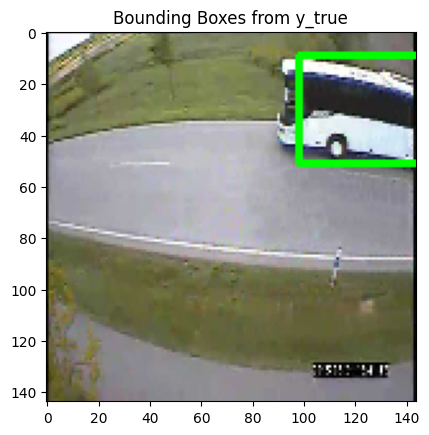

In [96]:
y_true = train_label_grid
tmp_path = 'dataset/images/train/00000004.jpg'
#image = cv2.imread(tmp_path)
image = original_image.copy()
image = preprocess_image(tmp_path)
boxes = decode_y_true_to_boxes(y_true[4], GRID_SIZE_1, IMG_SIZE_1)
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)

plt.imshow(image)
plt.title("Bounding Boxes from y_true")
plt.show()

In [91]:
#IMG_SIZE_1 = 128
IMG_SIZE_1 = 144
GRID_SIZE_1 = 9
# GRID_SIZE_1 = 5
CELL_SIZE_1 = IMG_SIZE_1 // GRID_SIZE_1
NUM_CLASSES = 10

In [119]:
def build_yolo_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE_1, IMG_SIZE_1, 3)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(GRID_SIZE_1 * GRID_SIZE_1 * (5 + NUM_CLASSES)),
        #layers.Dense(GRID_SIZE_1 * GRID_SIZE_1 * (5 + NUM_CLASSES), activation='sigmoid'),  # 5 outputs per grid cell
        #layers.Dense(GRID_SIZE_1 * GRID_SIZE_1 * (5 + NUM_CLASSES), activation='softmax'),
        layers.Reshape((GRID_SIZE_1, GRID_SIZE_1, 5 + NUM_CLASSES))

        # Output head: outputs per grid cell
        #output = layers.Conv2D((5 + NUM_CLASSES), (1, 1), activation='sigmoid')(x)  # shape: (GRID_SIZE, GRID_SIZE, 5+C)
        #model = tf.keras.Model(inputs=inputs, outputs=output)
    ])
    return model

model = build_yolo_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 144, 144, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 72, 72, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 36, 36, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1215)                │         623,295 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 9, 9, 15)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,029,663 (23.00 MB)

 Trainable params: 6,029,663 (23.00 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
def custom_loss(y_true, y_pred):
    # Coordinate loss (MSE)
    coord_loss = tf.reduce_sum(tf.square(y_true[..., :4] - y_pred[..., :4]))
    # Confidence loss (binary crossentropy)
    conf_loss = tf.reduce_sum(tf.square(y_true[..., 4] - y_pred[..., 4]))
    return coord_loss + conf_loss


In [170]:
def custom_yolo_loss(y_true, y_pred):
    #print("y_true shape:", y_true.shape)
    #print("y_pred shape:", y_pred.shape)
    # This is a simplified placeholder loss.
    # Proper YOLO loss is more complex and requires decoding predictions.
    
    # Masks
    object_mask = y_true[..., 4:5]
    # Coordinate loss: only where object exists
    #bbox_loss = tf.reduce_mean(tf.square(y_true[..., 0:4] - y_pred[..., 0:4]))
    bbox_loss = tf.reduce_sum(object_mask * tf.square(y_true[..., 0:4] - y_pred[..., 0:4])) / tf.reduce_sum(object_mask + 1e-6)

    # Objectness loss (using MSE or BCE)
    #obj_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true[..., 4], logits=y_pred[..., 4]))
    obj_loss = tf.reduce_mean(tf.square(y_true[..., 4] - tf.sigmoid(y_pred[..., 4])))
    
    # Class probability loss: only where object exists
    #class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true[..., 5:], logits=y_pred[..., 5:]))
    #class_loss = tf.reduce_mean(tf.nn.sparse_categorical_crossentropy(labels=y_true[..., 5:], logits=y_pred[..., 5:]))

    if y_true.shape[-1] > 5:  # if classification is used
        class_loss = tf.reduce_sum(object_mask * tf.nn.softmax_cross_entropy_with_logits(
                        labels=y_true[..., 5:], logits=y_pred[..., 5:])[..., tf.newaxis]) / tf.reduce_sum(object_mask + 1e-6)
    else:
        class_loss = 0.0

    total_loss = bbox_loss + obj_loss + class_loss
    return total_loss


In [97]:
def custom_yolo_loss_v1(y_true, y_pred):
    obj_mask = tf.expand_dims(y_true[..., 4], axis=-1)  # 1 where object present, else 0
    noobj_mask = 1.0 - obj_mask

    # Bounding Box Loss — only for cells with objects
    bbox_loss = tf.reduce_mean(obj_mask * tf.square(y_true[..., 0:4] - y_pred[..., 0:4]))

    # Objectness Loss — two parts: object & no-object
    obj_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true[..., 4], logits=y_pred[..., 4])
    obj_loss = tf.reduce_mean(obj_mask[..., 0] * obj_loss + 0.5 * noobj_mask[..., 0] * obj_loss)  # down-weight background

    # Class Loss — only for cells with objects
    class_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[..., 5:], logits=y_pred[..., 5:])
    class_loss = tf.reduce_mean(obj_mask[..., 0] * class_loss)

    total_loss = bbox_loss + obj_loss + class_loss
    return total_loss


In [98]:
train_img_array = np.array(train_img_resized)

In [ ]:
train_img_array[0]

In [99]:
train_label_array = np.array(train_label_target)

In [148]:
train_label_array.shape

(1406, 25, 5)

In [ ]:
train_label_array[0]

In [100]:
print("YOLO labels shape:", train_label_grid.shape)
print("Model output shape:", model.output_shape)

YOLO labels shape: (5, 9, 9, 15)
Model output shape: (None, 9, 9, 15)


In [120]:
model.compile(optimizer='adam', loss=custom_yolo_loss_v1, metrics=['accuracy'])
#history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.1)
history = model.fit(train_img_array, train_label_grid, epochs=100, batch_size=32, validation_split=0.1)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0617 - loss: 0.4513 - val_accuracy: 0.0988 - val_loss: 0.3191
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.1049 - loss: 0.3578 - val_accuracy: 0.0864 - val_loss: 0.2244
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.0957 - loss: 0.2097 - val_accuracy: 0.0617 - val_loss: 0.2448
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.0833 - loss: 0.1310 - val_accuracy: 0.0494 - val_loss: 0.3872
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.0710 - loss: 0.0804 - val_accuracy: 0.0741 - val_loss: 0.5246
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.0895 - loss: 0.0961 - val_accuracy: 0.0864 - val_loss: 0.5476
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.0957 - loss: 0.0705 - val_accuracy: 0.0741 - val_loss: 0.5288
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.0926 - loss: 0.0642 - val_accuracy: 0.0864 - val_

In [172]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
print(f" Loss :: {history.history['loss']}")
print(f" Accuracy :: {history.history['accuracy']}")
print(f" Validation Loss :: {history.history['val_loss']}")
print(f" Validation Accuracy :: {history.history['val_accuracy']}")

In [ ]:
# Plotting Training vs Validation Metrics

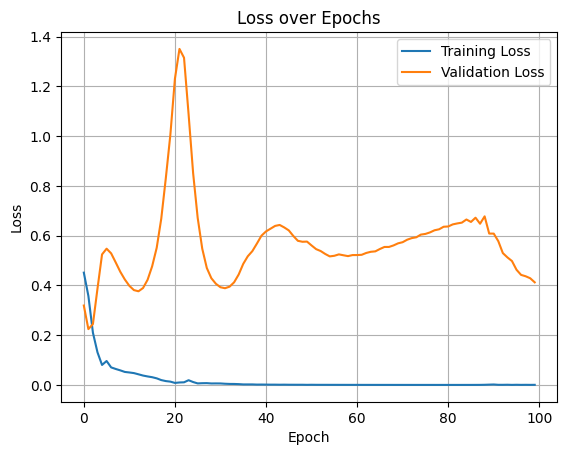

In [122]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

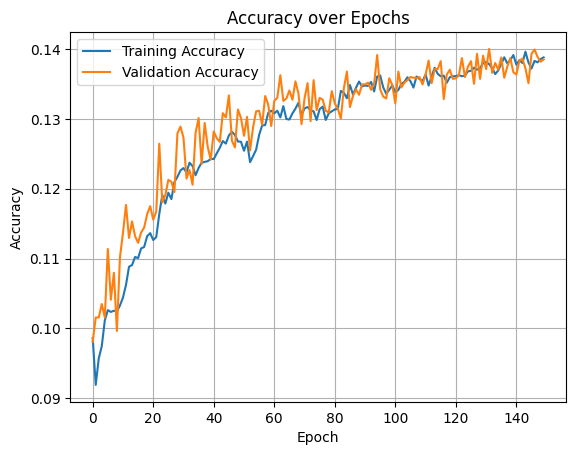

In [194]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
def predict_and_plot(model, image):
    pred = model.predict(image[np.newaxis, ...])[0]
    # print(pred)
    for i in range(GRID_SIZE_1):
        for j in range(GRID_SIZE_1):
            conf = pred[i, j, 4]
            print(conf)
            if conf > 0.5:
                x, y, w, h = pred[i, j, :4]
                cx = (j + x) * CELL_SIZE_1
                cy = (i + y) * CELL_SIZE_1
                w *= IMG_SIZE_1
                h *= IMG_SIZE_1
                x1 = int(cx - w / 2)
                y1 = int(cy - h / 2)
                x2 = int(cx + w / 2)
                y2 = int(cy + h / 2)
                plt.imshow(image)
                plt.gca().add_patch(plt.Rectangle((x1, y1), w, h, edgecolor='red', facecolor='none'))
                plt.title(f"Conf: {conf:.2f}")
                plt.show()
                return



In [ ]:
#image = train_img_resized[2]
#image[np.newaxis, ...][0]

In [ ]:
#predict_and_plot(model, X_test[0])
#predict_and_plot(model, train_img_resized[2])


In [ ]:
#output = model.predict(train_img_resized[2])

In [146]:
def draw_yolo_boxes(image, output, conf_threshold=0.5):
    grid_size = output.shape[0]  # 9
    cell_size = image.shape[0] // grid_size  # assuming square image
    boxes = []
    CLASS_NAMES = {
        0: "pickup_truck",
        1: "car",
        2: "articulated_truck",
        3: "bus",
        4: "motorized_vehicle",
        5: "work_van",
        6: "single_unit_truck",
        7: "pedestrian",
        8: "bicycle",
        9: "non-motorized_vehicle",
        10: "motorcycle"
    }

    for i in range(grid_size):
        for j in range(grid_size):
            cell = output[i, j]  # shape: (5 + NUM_CLASSES)
            x, y, w, h = cell[0:4]
            #print(x, y, w, h)
            obj_score = cell[4]
            #print(obj_score)
            if obj_score < conf_threshold:
                continue

            # Class prediction
            #class_probs = cell[5:]
            class_probs = tf.nn.softmax(cell[5:]).numpy()
            class_id = np.argmax(class_probs)
            class_name = CLASS_NAMES.get(class_id, "unknown")
            class_score = class_probs[class_id]

            # Convert to global image coordinates
            cx = (j + x) * cell_size  # grid x
            cy = (i + y) * cell_size  # grid y
            bw = w * image.shape[1]
            bh = h * image.shape[0]

            x1 = int(cx - bw / 2)
            y1 = int(cy - bh / 2)
            x2 = int(cx + bw / 2)
            y2 = int(cy + bh / 2)

            #boxes.append((x1, y1, x2, y2, class_id, obj_score * class_score))
            boxes.append((x1, y1, x2, y2, class_name, obj_score * class_score))

    return boxes

In [106]:
def visualize_boxes(image, boxes, class_names=None):
    image = image.copy()
    for (x1, y1, x2, y2, cls_id, score) in boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{class_names[cls_id] if class_names else cls_id}: {score:.2f}"
        cv2.putText(image, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return image

In [149]:
# 00000010.jpg,  00000020.jpg, 00000035.jpg, 00000050.jpg
train_source = 'C:\\Users\\Sonia\\Python_Programs\\Capstone-01\\01_Capstone-try1\\dataset\\images\\train\\00000002.jpg'
#test_source = 'C:\\Users\\Sonia\\Python_Programs\\Capstone-01\\01_Capstone-try1\\dataset\\images\\test\\00000010.jpg'
#test_results = model.predict(source = 'C:\\Users\\Sonia\\Python_Programs\\Capstone-01\\01_Capstone-try1\\dataset\\images\\test\\00000010.jpg',
                             #save = True, conf = 0.25)
# Read the image using OpenCV
test_image1 = cv2.imread(train_source)

# Convert the image from BGR to RGB (as YOLOv5 uses RGB)
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)

# Resize the image to 640x640 (YOLOv5 expects a 640x640 input)
# test_image1_resized = cv2.resize(test_image1, (128, 128))
test_image1_resized = cv2.resize(test_image1, (144, 144))

test_image1_resized = test_image1_resized/255.0

test_input_1 = np.expand_dims(test_image1_resized, axis=0).astype(np.float32)

print(test_input_1.shape)
#predict_and_plot(model, test_image1_resized)

print(type(test_input_1))
output = model.predict(test_input_1)[0]

# Ensure input is in float32 if required
# test_input = np.expand_dims(test_image1_resized, axis=0).astype(np.float32)
# print(test_input.shape)
#output = model.predict(test_input)


(1, 144, 144, 3)
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [108]:
print(test_input_1.shape)
print(np.min(test_input_1), np.max(test_input_1))

(1, 144, 144, 3)
0.0 1.0


In [109]:
print(output.shape)

(9, 9, 15)


In [ ]:
print(output)

In [ ]:
#predict_and_plot(model, test_input_1)

In [ ]:
test_input_1[0]

[(74, 115, 134, 135, 'motorized_vehicle', np.float32(6.5191097))]


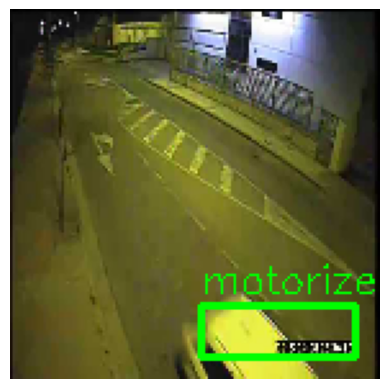

In [150]:
image = test_input_1[0]  # original input image

#boxes = draw_yolo_boxes(image, output, conf_threshold=0.5)
boxes = draw_yolo_boxes(image, output, conf_threshold=0.1)
print(boxes)
image_with_boxes = visualize_boxes((image * 255).astype(np.uint8), boxes, class_names=None)

plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

In [ ]:
# You can also access predictions programmatically
for result in test_results:
    print("Boxes:", result.boxes.xyxy)  # bounding boxes
    print("Scores:", result.boxes.conf)  # confidence scores
    print("Classes:", result.boxes.cls)  # predicted class ids
    # Show results
    result.show()

In [23]:
def convert_to_yolo_grid_format(labels, grid_size=9, num_classes=3, anchors_per_cell=1):
    """
    Convert label array of shape (batch, max_boxes, 5) to YOLO grid format:
    Output: (batch, grid_size, grid_size, anchors_per_cell * (5 + num_classes))
    """
    batch_size = labels.shape[0]
    max_boxes = labels.shape[1]
    grid_labels = np.zeros((batch_size, grid_size, grid_size, anchors_per_cell * (5 + num_classes)))

    for b in range(batch_size):
        for box in labels[b]:
            x, y, w, h, class_id = box
            if w == 0 or h == 0:
                continue  # skip padding boxes if any

            # Determine which grid cell the center of the box falls into
            grid_x = int(x * grid_size)
            grid_y = int(y * grid_size)

            if grid_x >= grid_size: grid_x = grid_size - 1
            if grid_y >= grid_size: grid_y = grid_size - 1

            # YOLO-style encoding: [x, y, w, h, objectness, class_one_hot...]
            # x, y, w, h remain normalized (relative to image)
            objectness = 1.0
            class_one_hot = np.zeros(num_classes)
            class_id = int(class_id)
            if class_id < num_classes:
                class_one_hot[class_id] = 1

            # Fill the anchor slot (assuming B=1)
            grid_labels[b, grid_y, grid_x, 0:4] = [x, y, w, h]
            grid_labels[b, grid_y, grid_x, 4] = objectness
            grid_labels[b, grid_y, grid_x, 5:] = class_one_hot

    return grid_labels

In [24]:
train_label_array.shape[0], train_label_array.shape[1]

(4500, 25)

In [25]:
num_classes = 10  # Set according to your dataset
train_label_grid = convert_to_yolo_grid_format(train_label_array, grid_size=9, num_classes=num_classes)

In [29]:
# Suppose num_classes = 10
#train_label_grid = tf.one_hot(train_label_grid, depth=num_classes)

In [26]:
print("YOLO labels shape:", train_label_grid.shape)
print("Model output shape:", model.output_shape)

YOLO labels shape: (4500, 9, 9, 15)
Model output shape: (None, 9, 9, 15)


In [ ]:
train_label_grid[0]